In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
df = pd.read_csv("loan.csv")

C:\Users\rober\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df["dateIssued"] = pd.to_datetime(df["issue_d"])

In [4]:
def getClass(status):
    if status=="Charged Off" or status=="Default" or status=="Does not meet the credit policy. Status:Charged Off" or status=="In Grace Period" or status=="Late (16-30 days)" or status=="Late (31-120 days)":
        return 0
    else:
        return 1
df["goodLoan"] = df["loan_status"].apply(lambda x: getClass(x))

In [5]:
midWest = ['IL', 'MO', 'MN', 'OH', 'WI', 'KS', 'MI', 'SD', 'IA', 'NE', 'IN', 'ND']
west = ['CA', 'OR', 'UT','WA', 'CO', 'NV', 'AK', 'MT', 'HI', 'WY', 'ID']
northEast = ['CT', 'NY', 'PA', 'NJ', 'RI','MA', 'MD', 'VT', 'NH', 'ME']
southEast = ['GA', 'NC', 'VA', 'FL', 'KY', 'SC', 'LA', 'AL', 'WV', 'DC', 'AR', 'DE', 'MS', 'TN' ]
southWest = ['AZ', 'TX', 'NM', 'OK']

df['region'] = np.nan

def getRegion(state):
    if state in west:
        return 'West'
    elif state in southWest:
        return 'SouthWest'
    elif state in southEast:
        return 'SouthEast'
    elif state in midWest:
        return 'MidWest'
    elif state in northEast:
        return 'NorthEast'
    


df['region'] = df['addr_state'].apply(lambda x: getRegion(x))

In [6]:
dfDateRegion = df.groupby(["dateIssued", "region"], as_index=False).sum()

dfDateRegion['monthYear'] = [month.to_period('M') for 
                          month in dfDateRegion['dateIssued']] #get year-month

dfDateRegion = dfDateRegion.groupby(['monthYear', 'region'], as_index=False).sum()
dfDateRegionFilter = dfDateRegion[["region", "monthYear", "loan_amnt"]]
dfGroupDateRegion = dfDateRegionFilter.groupby(['monthYear', 'region']).loan_amnt.sum()

<Figure size 1080x432 with 0 Axes>

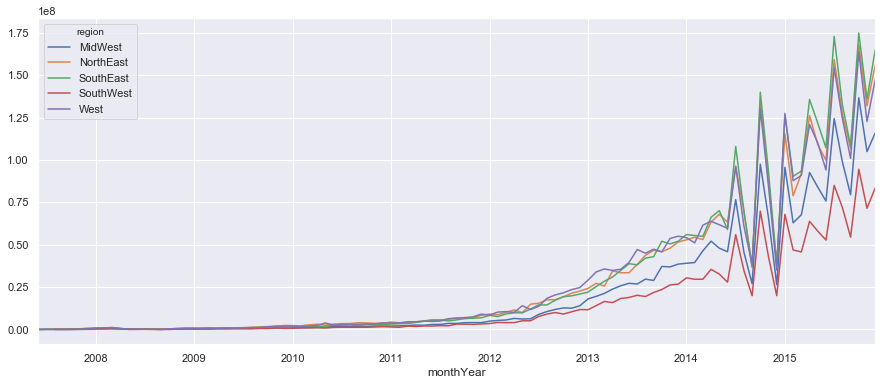

In [7]:
plt.figure(figsize=(15,6))
dfGroupDateRegion.unstack().plot(stacked=False, legend=True, figsize=(15,6))
#sns.lineplot(x="monthYear", y="loan_amnt", hue="region", data=dfDateRegionFilter)

# 1. EDA

Text(0.5, 1.0, 'Frequency of Good vs. Bad Loans')

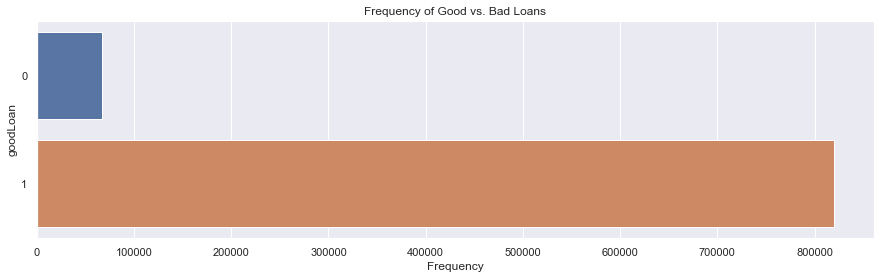

In [8]:
dfClassGrouped = df.groupby("goodLoan")["id"].count()
plt.figure(figsize=(15, 4))
sns.barplot(dfClassGrouped.values, dfClassGrouped.index, orient="h")
plt.xlabel("Frequency")
plt.title("Frequency of Good vs. Bad Loans")

In [9]:
dfClassGrouped.iloc[0]/dfClassGrouped.sum()

0.07598669790472842

Notice that bad loans only account for under 10% of total loans. This is particularly problematic if we run standard classification techniques, so implementing different sampling techniques will be required to optimize model performance. Before we do so, however, we will perform some basic EDA to answer where and why bad loans occur.

## Analysis by Region and State

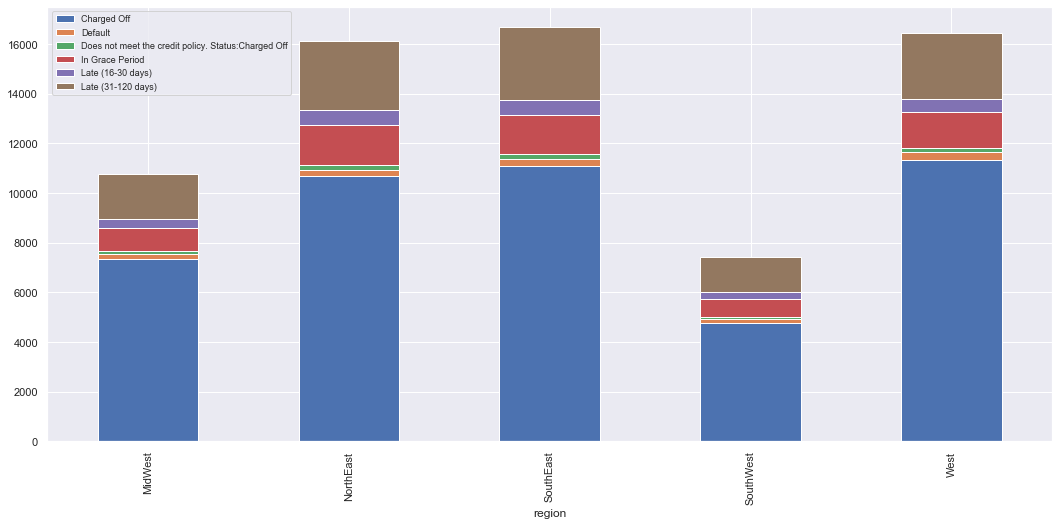

In [10]:
dfBadLoans = df[df["goodLoan"]==0]
dfClassGrouped = dfBadLoans.groupby(["region", "loan_status"])["id"].count()
dfClassGrouped.unstack().plot.bar(stacked=True, figsize=(18, 8))
plt.legend(loc=2, prop={'size': 9})

In [11]:
dfRegionGrouped = df.groupby(["region", "goodLoan"])["id"].count()
dfRegionGrouped = dfRegionGrouped.unstack()
dfRegionGrouped["prop0"] = dfRegionGrouped[0]/(dfRegionGrouped[0]+dfRegionGrouped[1])
dfRegionGrouped["prop1"] = 1-dfRegionGrouped["prop0"]
dfRegionGrouped[["prop0", "prop1"]]

goodLoan,prop0,prop1
region,,
MidWest,0.069522,0.930478
NorthEast,0.078929,0.921071
SouthEast,0.077705,0.922295
SouthWest,0.070830,0.929170
West,0.078723,0.921277


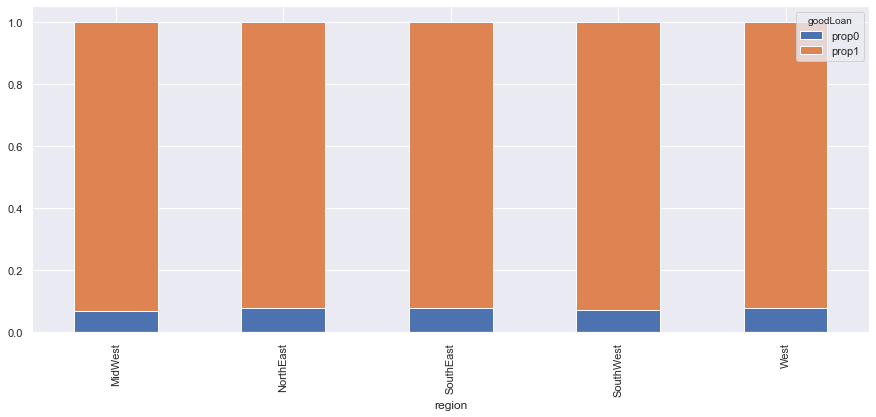

In [12]:
dfRegionGrouped[["prop0", "prop1"]].plot.bar(stacked=True, figsize=(15, 6))

Not too much discrepancy between the number of bad loans between region.

In [13]:
dfStatesLoan = df.groupby("addr_state")["loan_amnt"].agg([("loanMedian", "median"), ("loanAvg", "mean"), ("loanCount", "count")])
dfStatesLoan.sort_values("loanMedian", ascending=False).head()

,loanMedian,loanAvg,loanCount
addr_state,,,
AK,15500.0,16770.090703,2205
MA,14400.0,15679.331569,20593
VA,14400.0,15662.618549,26255
TX,14400.0,15591.239211,71138
ND,14400.0,15547.599165,479


(12000, 18000)

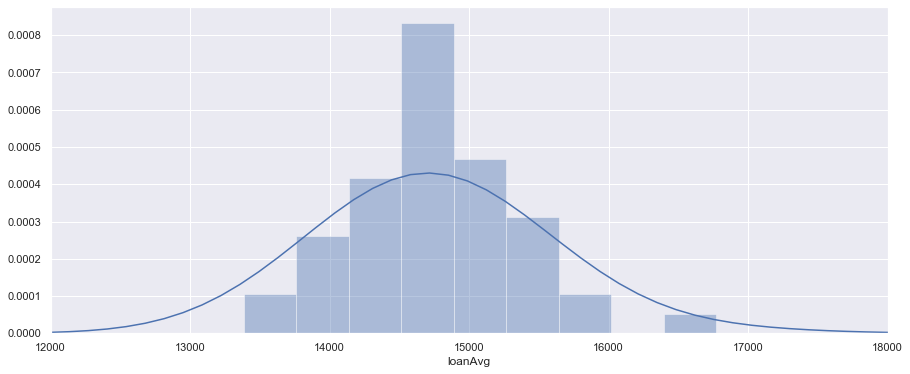

In [50]:
plt.figure(figsize=(15, 6))
sns.distplot(dfStatesLoan["loanAvg"])
plt.xlim((12000, 18000))

Most loans hover around $14000-15000. Not a huge significant difference from state to state...

In [15]:
dfStatesLoan.sort_values("loanCount", ascending=False).head()

,loanMedian,loanAvg,loanCount
addr_state,,,
CA,12700.0,14655.568381,129517
NY,12500.0,14536.376306,74086
TX,14400.0,15591.239211,71138
FL,12000.0,13932.700008,60935
IL,14000.0,15195.299639,35476


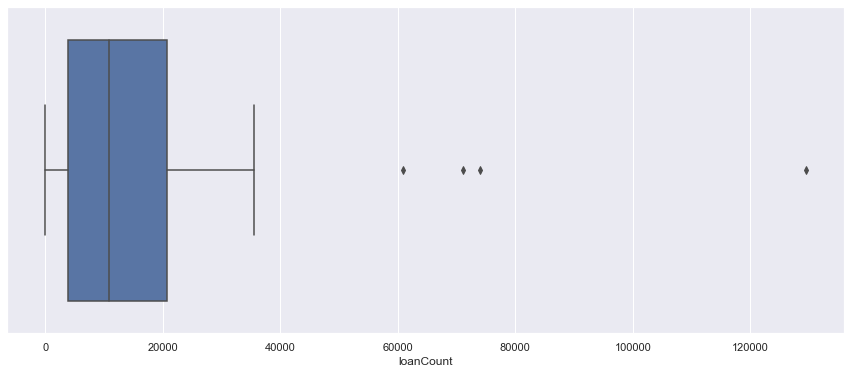

In [16]:
plt.figure(figsize=(15, 6))
sns.boxplot(dfStatesLoan["loanCount"])

There do seem to be a couple of states (top 4) that have significantly higher loan counts compared to other states. We need to analyze whether or not the proportion of bad loans in these states are inflated as well.

In [17]:
dfStateBadLoan = df.groupby("addr_state")["goodLoan"].agg([("sumGoodLoan", "sum"), ("totalLoans", "count")])
dfStateBadLoan["sumBadLoan"] = dfStateBadLoan["totalLoans"] - dfStateBadLoan["sumGoodLoan"]
dfStateBadLoan["propBadLoan"] = dfStateBadLoan["sumBadLoan"]/dfStateBadLoan["totalLoans"]

propBadLoan = np.mean(dfStateBadLoan["propBadLoan"])
dfStateBadLoan["devMean"] = dfStateBadLoan["propBadLoan"]-propBadLoan

dfStateBadLoan.sort_values("propBadLoan", ascending=False).head()

,sumGoodLoan,totalLoans,sumBadLoan,propBadLoan,devMean
addr_state,,,,,
IA,11,14,3,0.214286,0.142160
NV,11270,12443,1173,0.094270,0.022144
HI,4143,4570,427,0.093435,0.021310
AL,10207,11200,993,0.088661,0.016535
NY,67797,74086,6289,0.084888,0.012762


In [18]:
dfStateBadLoan = dfStateBadLoan.reset_index()
dfStateBadLoan[dfStateBadLoan["addr_state"].isin(["CA", "NY", "TX", "FL"])]

,addr_state,sumGoodLoan,totalLoans,sumBadLoan,propBadLoan,devMean
4,CA,118999,129517,10518,0.081209,0.009084
9,FL,55787,60935,5148,0.084483,0.012358
34,NY,67797,74086,6289,0.084888,0.012762
43,TX,66379,71138,4759,0.066898,-0.005228


Not too much difference from the average proportion of bad loans from other states...

## Analysis by Income Level

In [19]:
df = df.dropna(subset=["annual_inc"])

In [20]:
dictIncome = {}
for i in range(1,100):
    dictIncome[i] = np.percentile(df["annual_inc"], i)
seriesIncome = pd.Series(dictIncome)

Text(0, 0.5, 'Annual Income')

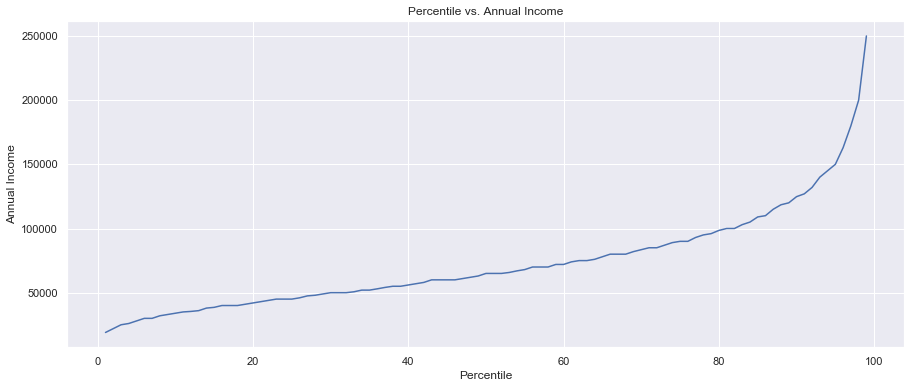

In [21]:
plt.figure(figsize=(15, 6))
sns.lineplot(list(dictIncome.keys()), list(dictIncome.values()))
plt.title("Percentile vs. Annual Income")
plt.xlabel("Percentile")
plt.ylabel("Annual Income")

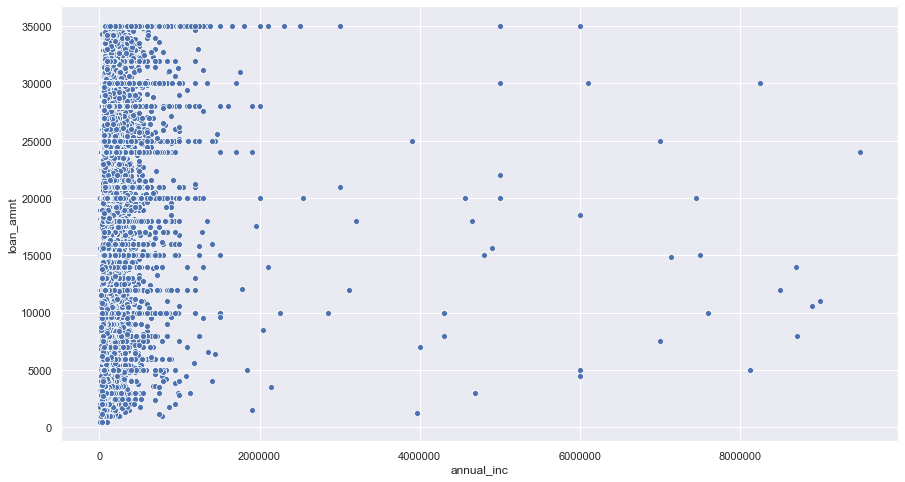

In [22]:
plt.figure(figsize=(15, 8))
sns.scatterplot(df["annual_inc"], df["loan_amnt"])

Can't really get much analysis with this. Perhaps turn annual income into a categorical variable: <br>
Low income: 0-50K<br>
Middle income: 50-100K<br>
High income: 100K+<br>

In [23]:
def getIncomeCat(income):
    if income<50000:
        return "Low"
    elif income>=50000 and income<100000:
        return "Middle"
    else: 
        return "High"
df["incomeCat"] = df["annual_inc"].apply(lambda x: getIncomeCat(x))

C:\Users\rober\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


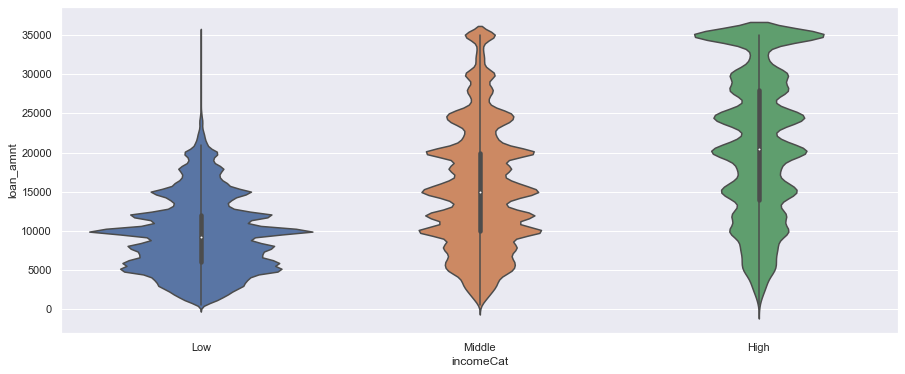

In [24]:
plt.figure(figsize=(15, 6))
sns.violinplot(x="incomeCat", y="loan_amnt", data=df)

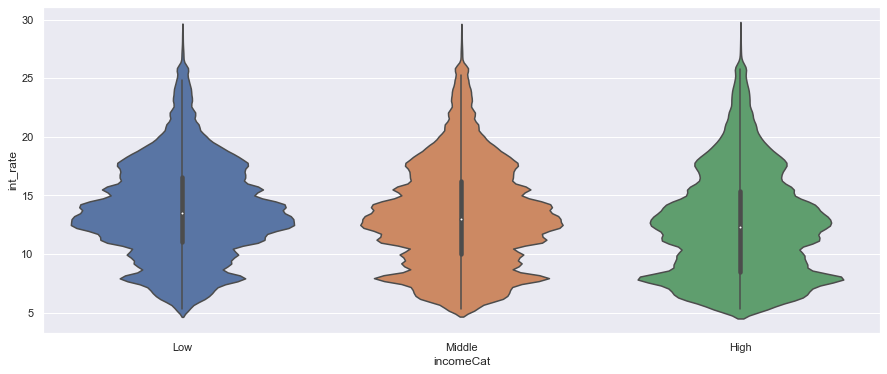

In [25]:
plt.figure(figsize=(15, 6))
sns.violinplot(x="incomeCat", y="int_rate", data=df)

Text(0.5, 1.0, 'Percentage of Good/Bad Loans by Income Category')

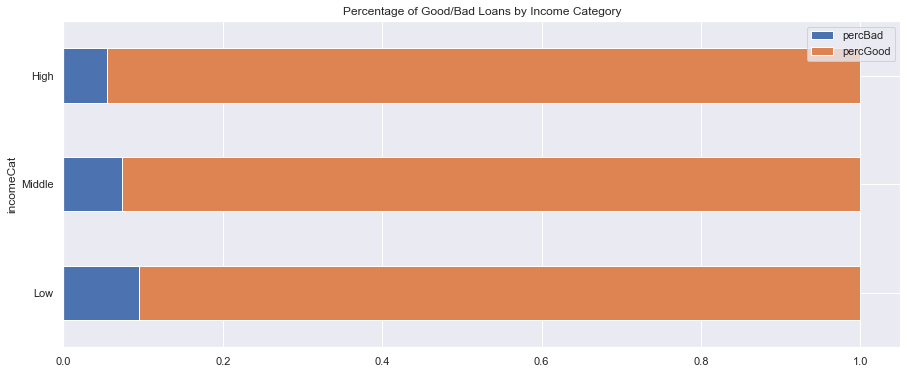

In [26]:
dfIncomeGrouped = df.groupby("incomeCat")["goodLoan"].agg([("totalLoans", "count"), ("goodLoans", "sum")])
dfIncomeGrouped["percBad"] = (dfIncomeGrouped["totalLoans"]-dfIncomeGrouped["goodLoans"])/dfIncomeGrouped["totalLoans"]
dfIncomeGrouped["percGood"] = 1-dfIncomeGrouped["percBad"]
dfIncomeGrouped = dfIncomeGrouped.sort_values("percBad", ascending=False)
dfIncomeGrouped[["percBad", "percGood"]].plot.barh(stacked=True, figsize=(15, 6))
plt.title("Percentage of Good/Bad Loans by Income Category")

In [27]:
dfIncomeGrouped

,totalLoans,goodLoans,percBad,percGood
incomeCat,,,,
Low,260560,235932,0.094519,0.905481
Middle,451921,418768,0.073360,0.926640
High,174894,165246,0.055165,0.944835


There is a clear distinction between the different income levels for good/bad loans. Lower income individuals tend to have get smaller amounts of loans, but have a higher percentage of bad loans with higher interest rates compared to middle/higher income individuals.

## Analysis by Credit Score

In [28]:
dfCreditGrouped = df.groupby("grade")["goodLoan"].agg([("totalLoans", "count"), ("goodLoans", "sum")])
dfCreditGrouped["percBad"] = (dfCreditGrouped["totalLoans"]-dfCreditGrouped["goodLoans"])/dfCreditGrouped["totalLoans"]
dfCreditGrouped["percGood"] = 1-dfCreditGrouped["percBad"]
dfCreditGrouped = dfCreditGrouped.sort_values("percBad", ascending=False)
dfCreditGrouped

,totalLoans,goodLoans,percBad,percGood
grade,,,,
G,5489,4220,0.231190,0.768810
F,23046,18663,0.190185,0.809815
E,70705,60960,0.137826,0.862174
D,139542,123683,0.113650,0.886350
C,245860,226806,0.077499,0.922501
B,254535,241079,0.052865,0.947135
A,148198,144535,0.024717,0.975283


Text(0.5, 1.0, 'Percentage of Good/Bad Loans by Income Category')

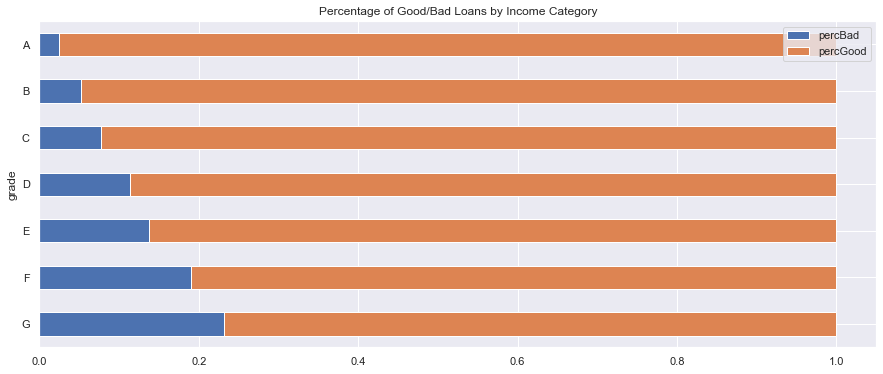

In [29]:
dfCreditGrouped[["percBad", "percGood"]].plot.barh(stacked=True, figsize=(15, 6))
plt.title("Percentage of Good/Bad Loans by Income Category")

In [30]:
dfSubCreditGrouped = df.groupby("sub_grade")["goodLoan"].agg([("totalLoans", "count"), ("goodLoans", "sum")])
dfSubCreditGrouped["percBad"] = (dfSubCreditGrouped["totalLoans"]-dfSubCreditGrouped["goodLoans"])/dfSubCreditGrouped["totalLoans"]
dfSubCreditGrouped["percGood"] = 1-dfSubCreditGrouped["percBad"]
dfSubCreditGrouped = dfSubCreditGrouped.sort_values("percBad", ascending=False)
dfSubCreditGrouped.head()

,totalLoans,goodLoans,percBad,percGood
sub_grade,,,,
G5,576,422,0.267361,0.732639
F5,2594,1988,0.233616,0.766384
G1,1871,1439,0.230893,0.769107
G3,981,755,0.230377,0.769623
G2,1398,1086,0.223176,0.776824


Text(0.5, 1.0, 'Percentage of Good/Bad Loans by Income Category')

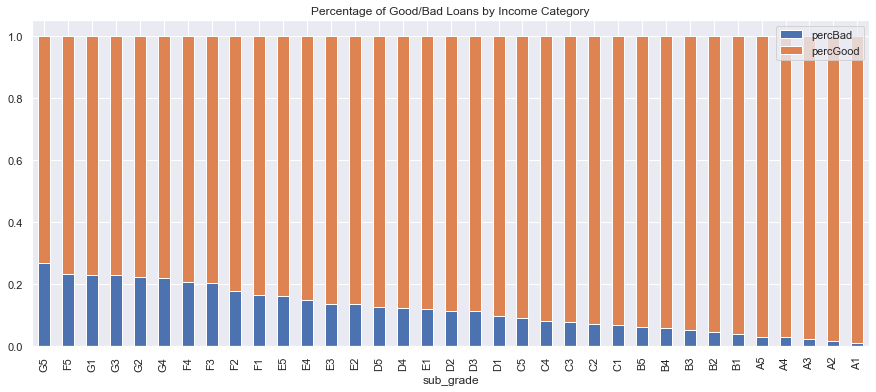

In [31]:
dfSubCreditGrouped[["percBad", "percGood"]].plot.bar(stacked=True, figsize=(15, 6))
plt.title("Percentage of Good/Bad Loans by Income Category")

Our analysis supports our intuition, the higher the credit grade, the smaller the % of bad loans given.

## Analysis on Purpose

In [32]:
dfPurposeGrouped = df.groupby("purpose")["goodLoan"].agg([("totalLoans", "count"), ("goodLoans", "sum")])
dfPurposeGrouped["percBad"] = (dfPurposeGrouped["totalLoans"]-dfPurposeGrouped["goodLoans"])/dfPurposeGrouped["totalLoans"]
dfPurposeGrouped["percGood"] = 1-dfPurposeGrouped["percBad"]
dfPurposeGrouped = dfPurposeGrouped.sort_values("percBad", ascending=False)
dfPurposeGrouped

,totalLoans,goodLoans,percBad,percGood
purpose,,,,
educational,423,335,0.208038,0.791962
small_business,10377,8596,0.171630,0.828370
renewable_energy,575,503,0.125217,0.874783
wedding,2347,2058,0.123136,0.876864
house,3707,3290,0.112490,0.887510
moving,5414,4807,0.112117,0.887883
other,42890,38727,0.097062,0.902938
medical,8540,7736,0.094145,0.905855
vacation,4736,4334,0.084882,0.915118


Text(0.5, 1.0, 'Percentage of Good/Bad Loans by Purpose')

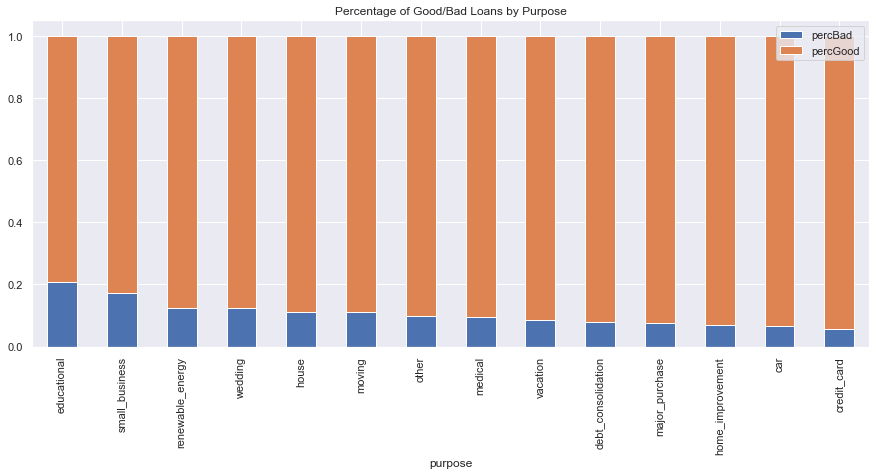

In [33]:
dfPurposeGrouped[["percBad", "percGood"]].plot.bar(stacked=True, figsize=(15, 6))
plt.title("Percentage of Good/Bad Loans by Purpose")

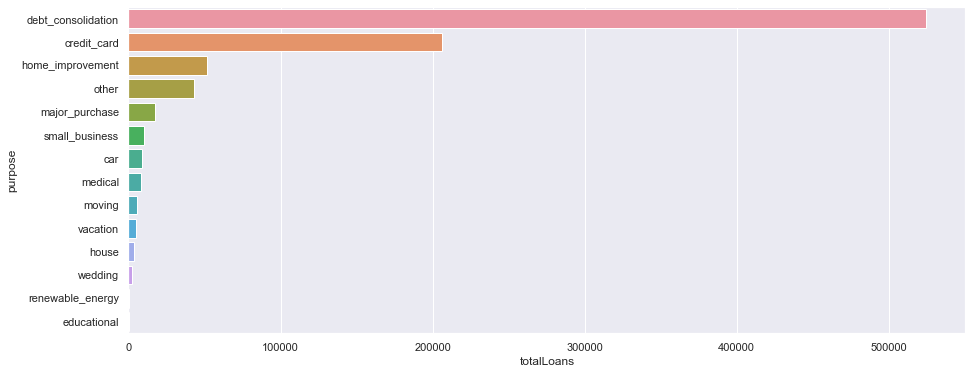

In [34]:
dfPurposeGrouped = dfPurposeGrouped.reset_index().sort_values("totalLoans", ascending=False)
plt.figure(figsize=(15, 6))
sns.barplot(y=dfPurposeGrouped["purpose"], x=dfPurposeGrouped["totalLoans"])

In [51]:
dfPurposeGrouped2 = dfPurposeGrouped.unstack()[["totalLoans"]]
dfPurposeGrouped2["highPerc"] = dfPurposeGrouped2["totalLoans"]["High"]/(dfPurposeGrouped2["totalLoans"]["High"]+dfPurposeGrouped2["totalLoans"]["Middle"]+dfPurposeGrouped2["totalLoans"]["Low"])
dfPurposeGrouped2["midPerc"] = dfPurposeGrouped2["totalLoans"]["Middle"]/(dfPurposeGrouped2["totalLoans"]["High"]+dfPurposeGrouped2["totalLoans"]["Middle"]+dfPurposeGrouped2["totalLoans"]["Low"])
dfPurposeGrouped2["lowPerc"] = dfPurposeGrouped2["totalLoans"]["Low"]/(dfPurposeGrouped2["totalLoans"]["High"]+dfPurposeGrouped2["totalLoans"]["Middle"]+dfPurposeGrouped2["totalLoans"]["Low"])
dfPurposeGrouped2[["highPerc", "midPerc", "lowPerc"]].plot.bar(stacked=True, figsize=(15, 6))

KeyError: 'High'

Educational and small business have the highest proportion of bad loans. However, the amount of educational loans is relatively low, but the amount of small business loans is quite substantial. Debt consolidation, home improvement, and credit card loans account for most of the total loans, but have relatively low bad loan rates. More individuals with lower income tend to take out loans related to small business and home improvement. Loans related to car, education, and vacations are taken out higher for higher income individauls 

## Analysis on Interest Rates

C:\Users\rober\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


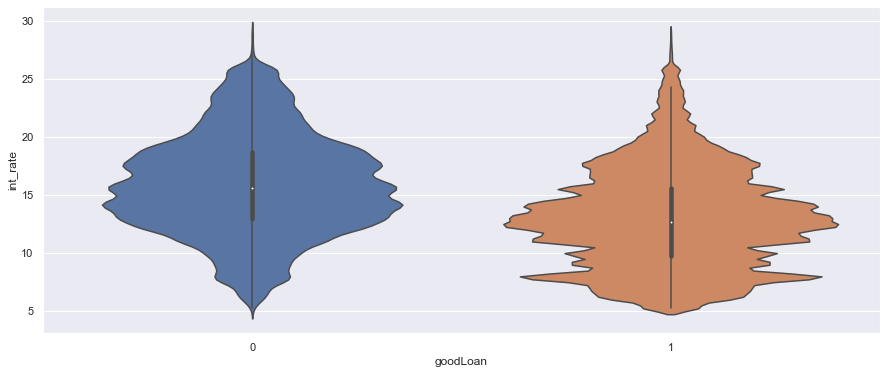

In [36]:
plt.figure(figsize=(15, 6))
sns.violinplot(y=df["int_rate"], x=df["goodLoan"])

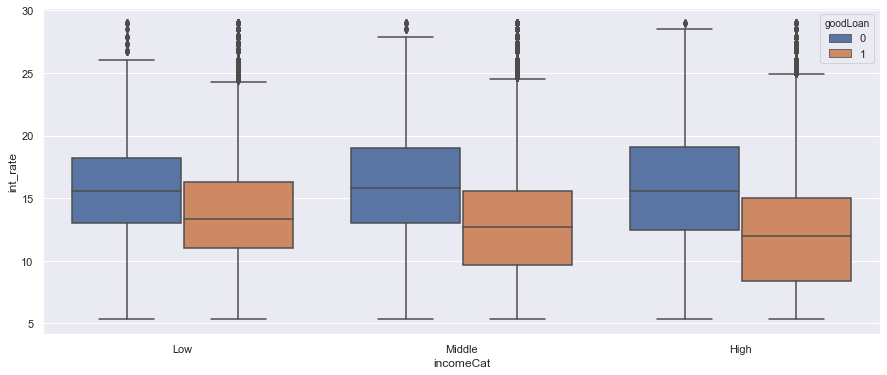

In [37]:
plt.figure(figsize=(15,6))
sns.boxplot("incomeCat", "int_rate", hue="goodLoan", data=df)

C:\Users\rober\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


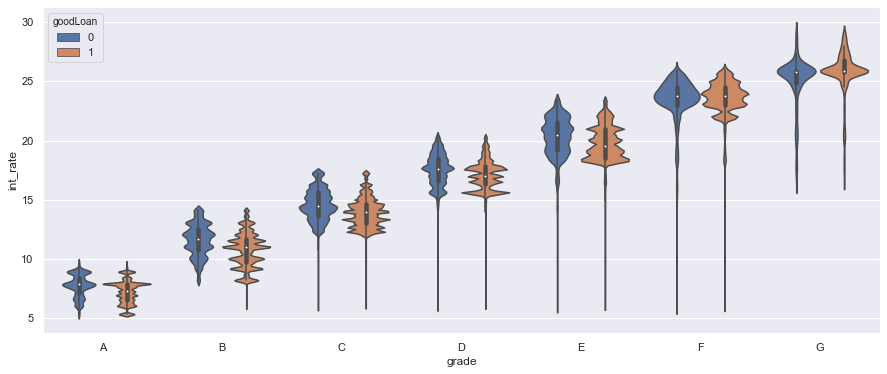

In [38]:
plt.figure(figsize=(15,6))
sns.violinplot("grade", "int_rate", hue="goodLoan", data=df, order=["A", "B", "C", "D", "E", "F", "G"])

A worse credit score tends to have higher interest rate, regardless if it's a good or bad loan.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text xticklabel objects>)

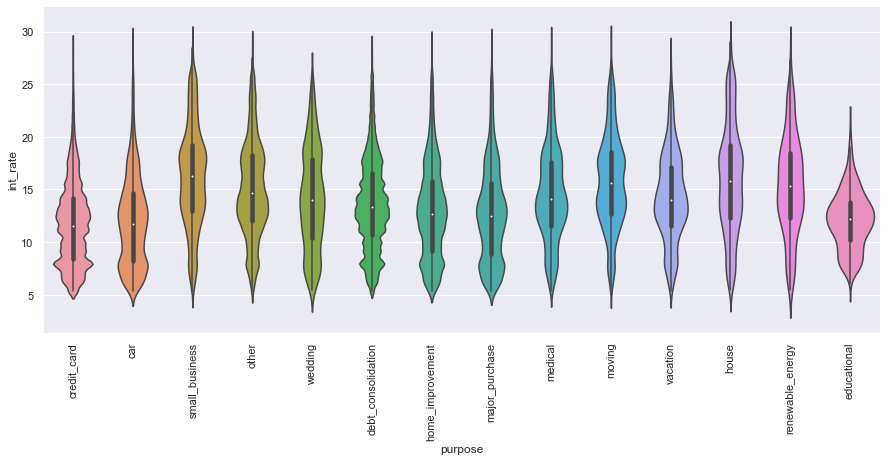

In [39]:
plt.figure(figsize=(15, 6))
sns.violinplot(y=df["int_rate"], x=df["purpose"])
plt.xticks(rotation=90)

Interest rates on bad loans are higher than good loans, and typically higher on small business loans. This may be attributed to the fact that small business loans have a higher percentage of bad loans taken out.

## Analysis on Trend

In [40]:
dfDatePurpose = df.groupby(["dateIssued", "purpose"], as_index=False).sum()

dfDatePurpose['monthYear'] = [month.to_period('M') for 
                          month in dfDatePurpose['dateIssued']] #get year-month

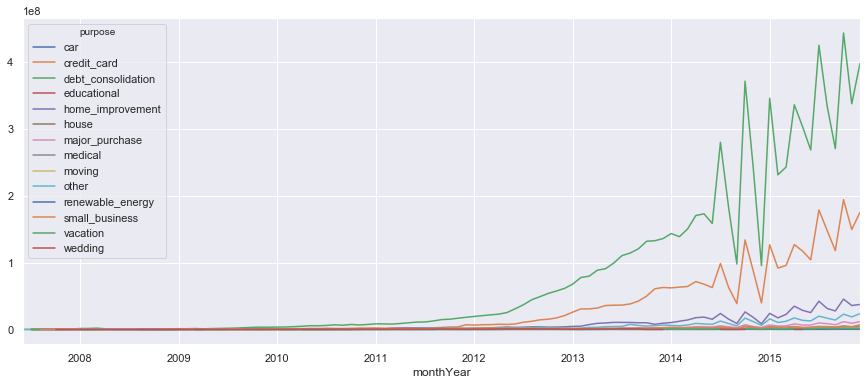

In [41]:
dfDatePurpose = dfDatePurpose.groupby(['monthYear', 'purpose'], as_index=False).mean()
dfDatePurposeFilter = dfDatePurpose[["purpose", "monthYear", "loan_amnt"]]
dfDatePurposeGrouped = dfDatePurposeFilter.groupby(["monthYear", "purpose"])["loan_amnt"].mean()
dfDatePurposeGrouped.unstack().plot(stacked=False, legend=True, figsize=(15,6))

In [42]:
df['monthYear'] = [month.to_period('M') for 
                          month in df['dateIssued']] #get year-month

In [43]:
dfBadLoansTrend = df.groupby(["monthYear"])["goodLoan"].agg([("total", "count"), ("good", "sum")])

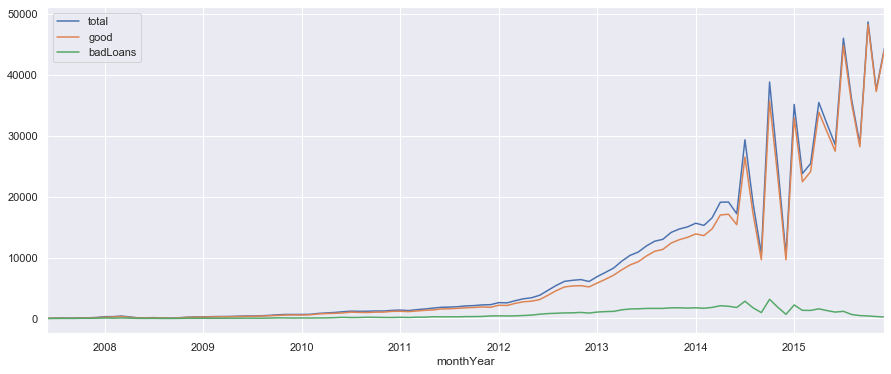

In [44]:
dfBadLoansTrend["badLoans"] = dfBadLoansTrend["total"] - dfBadLoansTrend["good"]
dfBadLoansTrend.plot(figsize=(15, 6))

In [45]:
dt_series = pd.to_datetime(df['issue_d'])
df['year'] = dt_series.dt.year

In [46]:
dfIntRateTrend = df.groupby(["year", "goodLoan"])["int_rate"].agg([("median", "median")])

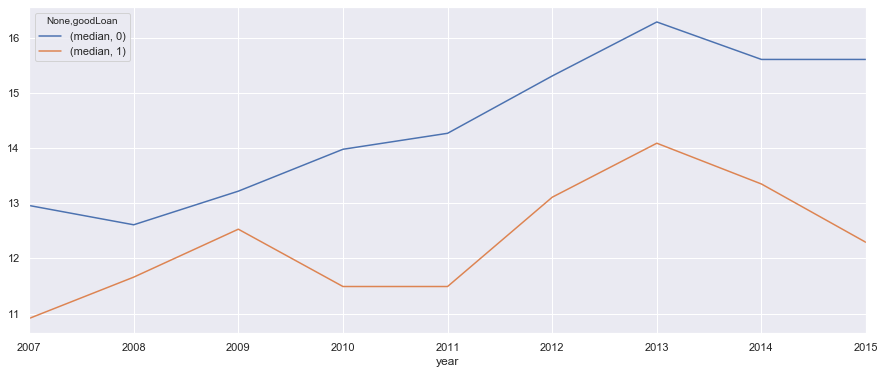

In [47]:
dfIntRateTrend.unstack().plot(figsize=(15, 6))

Interest rates see a spike for both good and bad loans in 2013. May be external factors causing this spike.

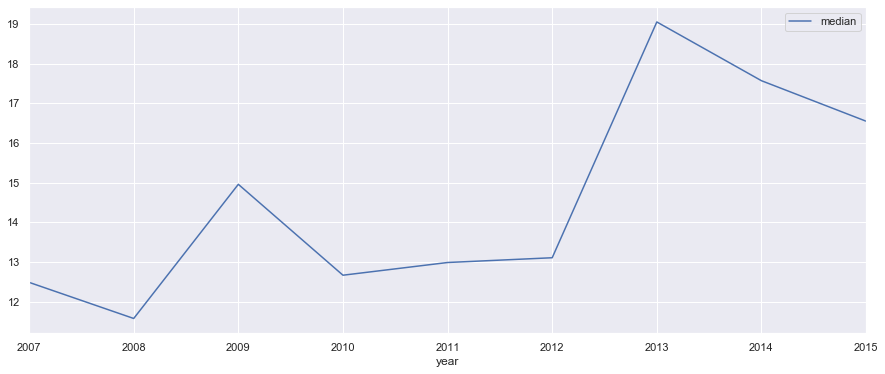

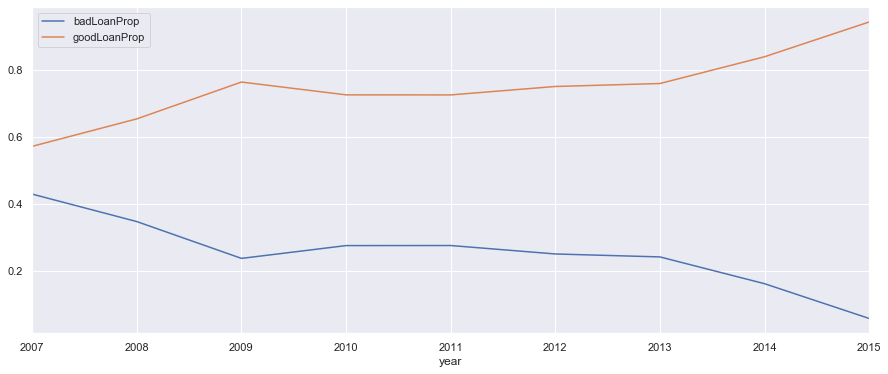

In [48]:
dfSmallBusinessInt = df[df["purpose"]=="small_business"]
dfSmallBusinessIntGrouped = dfSmallBusinessInt.groupby("year")["int_rate"].agg([("median", "median")])
dfSmallBusinessCountGrouped = dfSmallBusinessInt.groupby("year")["goodLoan"].agg([("total", "count"), ("good", "sum")])
dfSmallBusinessCountGrouped["badLoans"] = dfSmallBusinessCountGrouped["total"]-dfSmallBusinessCountGrouped["good"]
dfSmallBusinessCountGrouped["badLoanProp"] = dfSmallBusinessCountGrouped["badLoans"]/dfSmallBusinessCountGrouped["total"]
dfSmallBusinessCountGrouped["goodLoanProp"] = dfSmallBusinessCountGrouped["good"]/dfSmallBusinessCountGrouped["total"]
dfSmallBusinessIntGrouped.plot(figsize=(15, 6))
dfSmallBusinessCountGrouped[["badLoanProp", "goodLoanProp"]].plot(figsize=(15, 6))

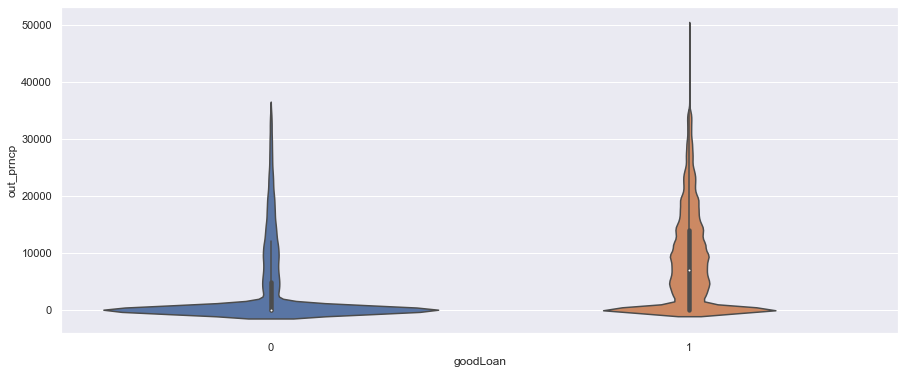

In [49]:
plt.figure(figsize=(15, 6))
sns.violinplot(df["goodLoan"], df["out_prncp"])

## 2. Classification of Good/Bad Loans

In [94]:
finaldf = df.copy()
"""
pub_rec - # of accounts client is delinquent
total_acc - # of credit lines the borrower has
delinq_2yrs - # of delinquencies in past 2 yrs
"""
finaldf = finaldf[['loan_amnt', "region", "incomeCat", 'term', 'int_rate', 'installment', 'grade',
       'home_ownership', 'annual_inc', 'verification_status', 'pymnt_plan',
       'purpose', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 
       'goodLoan', 'mths_since_last_major_derog', 'collection_recovery_fee', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
        'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee', 'recoveries',
        'last_pymnt_amnt']]

In [95]:
finaldf["mths_since_last_delinq"] = finaldf["mths_since_last_delinq"].fillna(0)
finaldf["mths_since_last_record"] = finaldf["mths_since_last_record"].fillna(0)
finaldf["mths_since_last_major_derog"] = finaldf["mths_since_last_major_derog"].fillna(0)

finaldf["delinq_2yrs"] = finaldf.groupby("region")["delinq_2yrs"].transform(lambda x: x.fillna(x.median()))
finaldf["inq_last_6mths"] = finaldf.groupby("region")["inq_last_6mths"].transform(lambda x: x.fillna(x.median()))
finaldf["total_acc"] = finaldf.groupby("region")["total_acc"].transform(lambda x: x.fillna(x.median()))
finaldf["pub_rec"] = finaldf.groupby("region")["pub_rec"].transform(lambda x: x.fillna(x.median()))
finaldf["open_acc"] = finaldf.groupby("region")["open_acc"].transform(lambda x: x.fillna(x.median()))
finaldf["revol_util"] = finaldf.groupby("region")["revol_util"].transform(lambda x: x.fillna(x.median()))

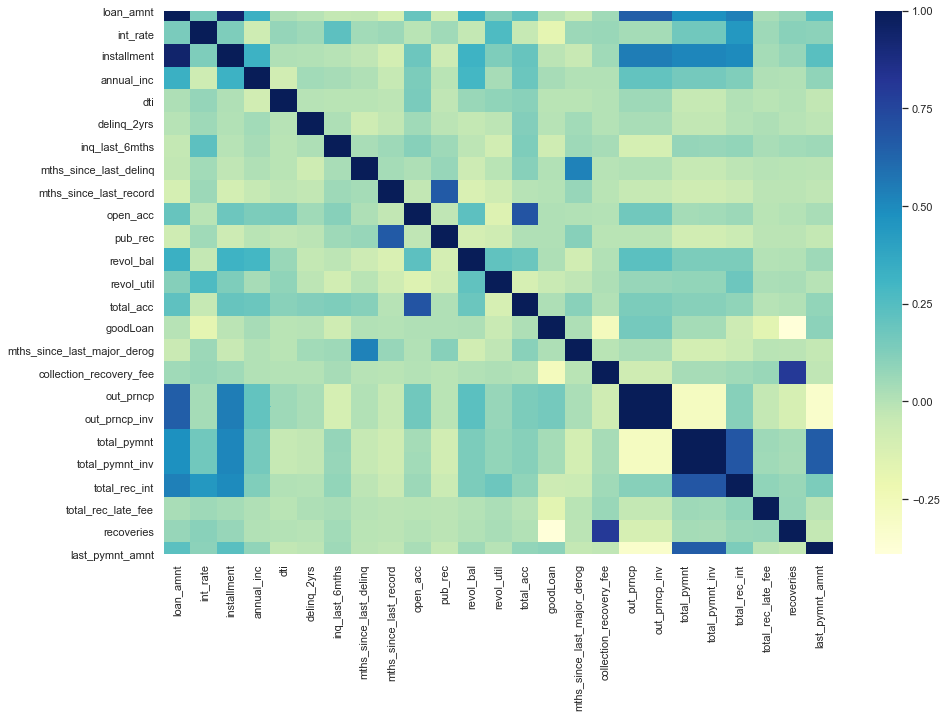

In [96]:
plt.figure(figsize=(15, 10))
sns.heatmap(finaldf.corr(), cmap="YlGnBu")

In [97]:
catCols = ["region", "incomeCat", "term", "grade", "home_ownership", "verification_status", "pymnt_plan", "purpose"]
finaldf = pd.get_dummies(finaldf, drop_first=True)

In [98]:
y = finaldf["goodLoan"]
finaldf = finaldf.drop(["goodLoan"], axis=1)
X = finaldf

In [99]:
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE
#from imblearn.metrics import classification_report_imbalanced

from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, f_classif, chi2
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
#import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV
#from xgboost import plot_importance
#from statsmodels.graphics.gofplots import ProbPlot
#import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import learning_curve
from scipy import stats
#import lightgbm as lgb

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# SGD

In [102]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier()
sgd_clf.fit(X_train, y_train)

C:\Users\rober\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [103]:
sgd_prediction = sgd_clf.predict(X_test)

0.9732442271047761
              precision    recall  f1-score   support

           0       0.98      0.66      0.79     22151
           1       0.97      1.00      0.99    270683

   micro avg       0.97      0.97      0.97    292834
   macro avg       0.98      0.83      0.89    292834
weighted avg       0.97      0.97      0.97    292834

[[0.98033821 0.01966179]
 [0.02713613 0.97286387]]


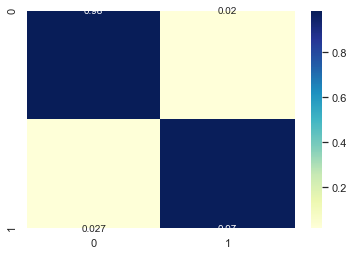

In [104]:
accuracy_sgd = accuracy_score(sgd_prediction, y_test)
print(accuracy_sgd)
#recall_sgd = recall_score(sgd_prediction, y_test)
#print(recall_sgd)
#num_zeros = (knn_prediction == 0).sum()
#num_ones = (knn_prediction == 1).sum()
#print(num_zeros)
#print(num_ones)
#print((sgd_prediction == 0).sum())
#print((sgd_prediction == 1).sum())
#print(len(sgd_prediction))
print(classification_report(y_test, sgd_prediction))
confusion_sgd = confusion_matrix(sgd_prediction, y_test)
confusion_sgd = confusion_sgd.astype('float') / confusion_sgd.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,6))
sns.heatmap(confusion_sgd, annot=True, cmap="YlGnBu")
plt.title("Confusion Matrix for SGD with SMOTE")

# SGD with SMOTE

In [124]:
sm = SMOTE(sampling_strategy='minority', random_state=42)
X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train)

In [125]:
sgd_clf = SGDClassifier()
sgd_clf.fit(X_train_sm, y_train_sm)

C:\Users\rober\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [126]:
sgd_prediction = sgd_clf.predict(X_test)

0.9693273322086916
              precision    recall  f1-score   support

           0       0.97      0.61      0.75     22151
           1       0.97      1.00      0.98    270683

   micro avg       0.97      0.97      0.97    292834
   macro avg       0.97      0.80      0.87    292834
weighted avg       0.97      0.97      0.97    292834

[[0.9735347  0.0264653 ]
 [0.03088241 0.96911759]]


Text(0.5, 1, 'Confusion Matrix for SGD with SMOTE')

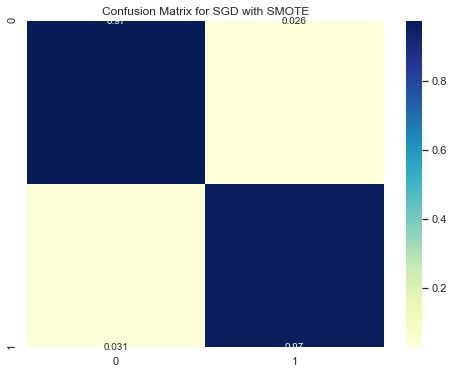

In [127]:
accuracy_sgd = accuracy_score(sgd_prediction, y_test)
print(accuracy_sgd)
#recall_sgd = recall_score(sgd_prediction, y_test)
#print(recall_sgd)
#num_zeros = (knn_prediction == 0).sum()
#num_ones = (knn_prediction == 1).sum()
#print(num_zeros)
#print(num_ones)
#print((sgd_prediction == 0).sum())
#print((sgd_prediction == 1).sum())
#print(len(sgd_prediction))
print(classification_report(y_test, sgd_prediction))
confusion_sgd = confusion_matrix(sgd_prediction, y_test)
confusion_sgd = confusion_sgd.astype('float') / confusion_sgd.sum(axis=1)[:, np.newaxis]
print(confusion_sgd)
plt.figure(figsize=(8,6))
sns.heatmap(confusion_sgd, annot=True, cmap="YlGnBu")
plt.title("Confusion Matrix for SGD with SMOTE")

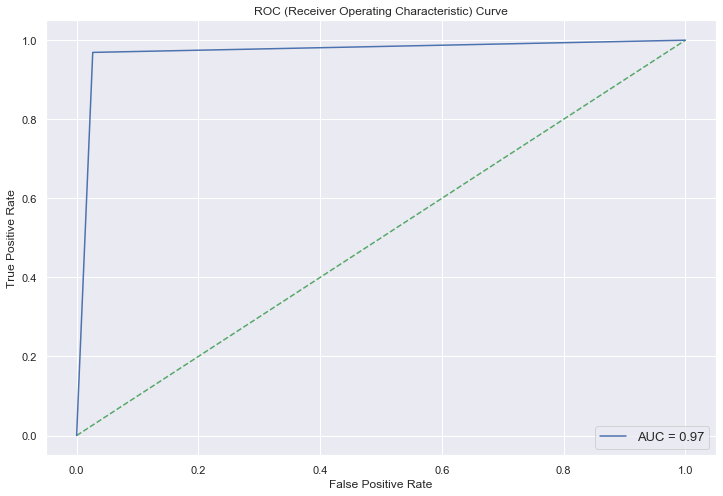

In [129]:
fpr, tpr, threshold = roc_curve(sgd_prediction, y_test)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12, 8))
plt.plot([0, 1], [0, 1],'g--')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right', prop={'size': 13})
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC (Receiver Operating Characteristic) Curve')
plt.show()

In [22]:
selector = SelectKBest(chi2, k="all").fit(X, y)
pVal = selector.pvalues_ #obtain p-value from F statistic
mapPVal = list(zip(pVal, X.columns)) #map column to its p-value
dfPVal = pd.Series({i[1]: i[0] for i in mapPVal}).reset_index().rename({"index": "feature", 0: "p-value"}, axis=1)
dfPVal.shape[0]

58